In [1]:
import os
import sys
import pandas as pd
import numpy as np
import pybedtools
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [3]:
mCpG = pd.read_table('../../data/Methylation/Au3_5mCpG_filtered.bed', sep='\t', header=None, comment='#')
mCpG.columns = ['Chr', 'Start', 'End', 'per', 'depth']
mCpG = mCpG[['Chr', 'Start', 'End']]
mCpG['Chr'] = mCpG['Chr'].astype(str)
mCpG['Start'] = mCpG['Start'].astype(int)
mCpG['End'] = mCpG['End'].astype(int)
mCpG['Chr'] = mCpG['Chr'].str.replace('CHR', 'Chr')
mCpG = pybedtools.BedTool.from_dataframe(mCpG) 

In [53]:
centromere = pd.read_excel('../../data/Au3_Centromere_EstimatedPosition.xlsx')
centromere.columns = ['Chr', 'Start', 'End']
centromere['Chr'] = centromere['Chr'].astype(str)
centromere['Start'] = centromere['Start'].astype(int)
centromere['End'] = centromere['End'].astype(int)
#Sort by chromosome and start position
centromere = centromere.sort_values(['Chr', 'Start'])

In [5]:
#load genome
Au3_genome_hapA = list(SeqIO.parse('../../data/Au3_CHR_hapA_v3.fasta', 'fasta'))
Au3_genome_hapB = list(SeqIO.parse('../../data/Au3_CHR_hapB_v3.fasta', 'fasta'))
Au3_genome = Au3_genome_hapA + Au3_genome_hapB
Au3_genome_renamed = []
for seq in Au3_genome:
    seqid_old = seq.id
    seq_seq = seq.seq
    if '_ab' in seq.id:
        seqnew = 'Chr14B'
    elif 'HapA' in seqid_old:
        #Add A to the end of the chromosome name
        seqnew = seq.id + 'A'
        seqnew = seqnew.replace('APSI_AU3_HapA_CHR', 'Chr')
    elif 'HapB' in seqid_old:
        #Add B to the end of the chromosome name
        seqnew = seq.id + 'B'
        seqnew = seqnew.replace('APSI_AU3_HapB_CHR', 'Chr')
    Au3_genome_renamed.append(SeqRecord(seq=seq_seq, id=seqnew, name=seqid_old, description=''))

In [8]:
centromere = pybedtools.BedTool.from_dataframe(centromere)

In [7]:
intersect = centromere.intersect(mCpG, wa=True, wb=True)
intersect = intersect.to_dataframe()

***** WARNING: File /tmp/pybedtools.t_szuyag.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	13511	13512

***** WARNING: File /tmp/pybedtools.t_szuyag.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	13511	13512



In [8]:
intersect['centromere-id'] = intersect['name'] + ':' + intersect['start'].astype(str) + '-' + intersect['end'].astype(str)
intersect_count = intersect.groupby('centromere-id').size().reset_index()

In [10]:
for item, row in intersect_count.iterrows():
    start = int(row['centromere-id'].split(':')[1].split('-')[0])
    end = int(row['centromere-id'].split(':')[1].split('-')[1])
    chr = row['centromere-id'].split(':')[0]
    seq = [x for x in Au3_genome_renamed if x.id == chr][0]
    intersect_count.loc[item, 'CpG'] = str(seq.seq[start:end]).upper().count('CG')
    intersect_count.loc[item, 'GpC'] = str(seq.seq[start:end]).upper().count('GC')

In [14]:
intersect_count.columns = ['centromere-id', '5mCpG_count', 'CpG', 'GpC']
intersect_count['5mCpG/CpG'] = intersect_count['5mCpG_count'] / intersect_count['CpG']
intersect_count['CpG/GpC'] = intersect_count['CpG'] / intersect_count['GpC']
intersect_count['Chr'] = intersect_count['centromere-id'].str.split(':').str[0]

/tmp/ipykernel_18699/584277385.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Chr', y=intersect_count['5mCpG/CpG']*100, data=intersect_count, color='skyblue', ci=None)


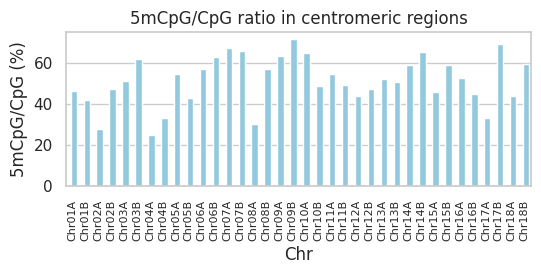

In [15]:
#Plot the 5mCpG/CpG 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
plt.figure(figsize=(6, 2))
sns.barplot(x='Chr', y=intersect_count['5mCpG/CpG']*100, data=intersect_count, color='skyblue', ci=None)
#Change bar width
for bar in plt.gca().patches:
    bar.set_width(0.5)
    bar.set_x(bar.get_x() + 0.25)
#rotate x-axis labels
plt.xticks(rotation=90)
#change x font size
plt.xticks(fontsize=8)
plt.ylabel('5mCpG/CpG (%)')
plt.title('5mCpG/CpG ratio in centromeric regions')
plt.show()

/tmp/ipykernel_18699/735460345.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Chr', y='CpG/GpC', data=intersect_count, color='skyblue', ci=None)


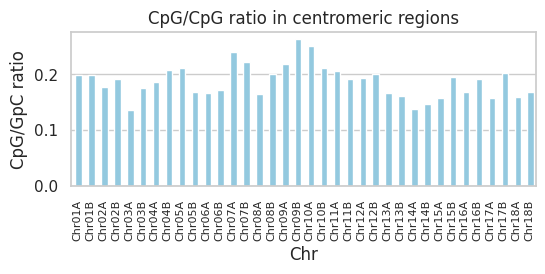

In [16]:
sns.set(style='whitegrid')
plt.figure(figsize=(6, 2))
sns.barplot(x='Chr', y='CpG/GpC', data=intersect_count, color='skyblue', ci=None)
#Change bar width
for bar in plt.gca().patches:
    bar.set_width(0.5)
    bar.set_x(bar.get_x() + 0.25)
#rotate x-axis labels
plt.xticks(rotation=90)
#change x font size
plt.xticks(fontsize=8)   
plt.ylabel('CpG/GpC ratio')
plt.title('CpG/CpG ratio in centromeric regions')
plt.show()

In [16]:
intersect2 = mCpG.intersect(centromere, wa=True, wb=True)
intersect2 = intersect2.to_dataframe()
intersect2

***** WARNING: File /tmp/pybedtools.15y0t328.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	5314443	7014443

***** WARNING: File /tmp/pybedtools.15y0t328.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	5314443	7014443



,chrom,start,end,name,score,strand
0,Chr01A,40803305,40803306,Chr01A,40800000,42300001
1,Chr01A,40806820,40806821,Chr01A,40800000,42300001
2,Chr01A,40807273,40807274,Chr01A,40800000,42300001
3,Chr01A,40807894,40807895,Chr01A,40800000,42300001
4,Chr01A,40808161,40808162,Chr01A,40800000,42300001
...,...,...,...,...,...,...
144453,Chr18B,4980163,4980164,Chr18B,4285349,4985349
144454,Chr18B,4980433,4980434,Chr18B,4285349,4985349
144455,Chr18B,4980792,4980793,Chr18B,4285349,4985349
144456,Chr18B,4981057,4981058,Chr18B,4285349,4985349


In [19]:
mCpG_bed = mCpG.to_dataframe()

In [4]:
TE_file = '../../data/TE/Au3_TE_mCpG_ratio.csv'
TE_df = pd.read_csv(TE_file, header=0, sep=',')

In [5]:
TE_df_bed = TE_df[['Chr', 'Start', 'End']]
TE_df_bed = pybedtools.BedTool.from_dataframe(TE_df_bed)

In [9]:
centromere_TE_intersect = centromere.intersect(TE_df_bed, wa=True, wb=True)

***** WARNING: File /tmp/pybedtools.d34tl6le.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	11973	14121

***** WARNING: File /tmp/pybedtools.d34tl6le.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	11973	14121



In [22]:
centromere_TE_intersect_bed = centromere_TE_intersect.to_dataframe()

In [23]:
centromere_TE_intersect_bed.columns = ['Chr', 'Start', 'End', 'TE_Chr', 'TE_Start', 'TE_End']
centromere_TE_intersect_bed['id'] = centromere_TE_intersect_bed['TE_Chr'] + ':' + centromere_TE_intersect_bed['TE_Start'].astype(str) + '-' + centromere_TE_intersect_bed['TE_End'].astype(str)

In [24]:
centromere_TE_intersect_bed = centromere_TE_intersect_bed.merge(TE_df, left_on='id', right_on='id', how='left')

In [25]:
centromere_TE_intersect_bed = centromere_TE_intersect_bed.drop(columns=['Chr_x', 'Start_x', 'End_x', 'Phase', 'Chr_y', 'Start_y', 'End_y'])

In [28]:
centromere_TE_intersect_bed['TE_family'] = centromere_TE_intersect_bed['TE_family'].str.split(':').str[1]

In [33]:
classify = pd.read_csv("/mnt/c/Users/lzy55/OneDrive - Australian National University/Scripts_backup/Apsi_genome_project/data/TE/Reclass_apsi_TE.csv")

In [37]:
classify['id'] =classify['chr']+ ':'+classify['start'].astype(str)+'-'+classify['end'].astype(str)
classify_table = classify[['id','new_name']]
classify_table['id'] = classify_table['id'].str.split('.').str[0]

/tmp/ipykernel_4708/1301132468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classify_table['id'] = classify_table['id'].str.split('.').str[0]


In [38]:
classify_table

,id,new_name
0,Chr01A:2-10118,TR
1,Chr01A:11363-11663,Class I:LARD:?
2,Chr01A:11836-12032,Class ?:LTR|TIR:?
3,Chr01A:11861-12030,Class I:LTR:Gypsy
4,Chr01A:12007-12150,Class II:TIR:?
...,...,...
2146012,Chr18B:26468955-26469569,Class I:LARD:?
2146013,Chr18B:26469027-26471931,Class II:TIR:?
2146014,Chr18B:26471912-26472005,Class I:LTR:Copia
2146015,Chr18B:26471926-26472443,Class I:LTR:Gypsy


In [39]:
centromere_TE_intersect_bed_join = pd.merge(centromere_TE_intersect_bed, classify_table, on='id', how='left')

In [41]:
centromere_TE_intersect_bed_join['length'] = centromere_TE_intersect_bed_join['TE_End']-centromere_TE_intersect_bed_join['TE_Start']

In [88]:
sum_TE_length = centromere_TE_intersect_bed_join.groupby(['TE_Chr', 'new_name'])['length'].sum().reset_index()
sum_TE_length2 = pd.DataFrame(sum_TE_length)
centromere2 = centromere.copy()
centromere2.columns = [col[0] for col in centromere2.columns]  # Flatten MultiIndex
centromere2 = centromere2.reset_index(drop=True)
centromere2.columns = ['TE_Chr', 'size']
sum_TE_length = pd.merge(sum_TE_length2, centromere2, on='TE_Chr' , how='left')
sum_TE_length['cov'] = sum_TE_length['length']*100/sum_TE_length['size']

In [55]:
centromere['size'] = centromere['End'] - centromere['Start']
centromere = centromere[['Chr','size']]

Text(0.5, 1.0, 'Coverage of TEs in centromeric regions in superfamily level')

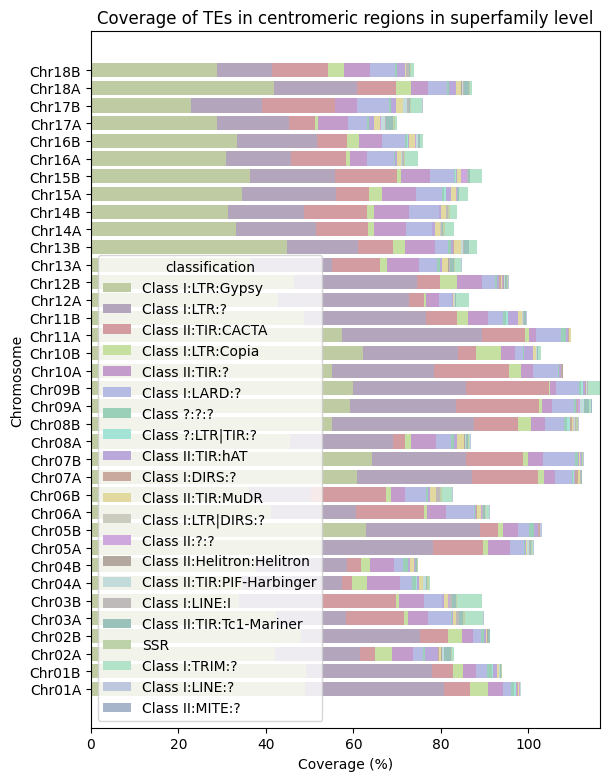

In [101]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 7.5))
from matplotlib import rcParams
rcParams['svg.fonttype'] = 'none'

chromosomes = sum_TE_length['TE_Chr'].unique()
bottom = np.zeros(len(chromosomes))
#sort by chromosome then sort by coverage
sum_TE_length = sum_TE_length.sort_values(by=['TE_Chr', 'cov'], ascending=[True, False])
#set different color for each superfamily
from matplotlib import cm
import random
unique_names = sum_TE_length['new_name'].unique()

# Generate muted colors by limiting the RGB range to a softer spectrum
def generate_muted_color():
    return (random.uniform(0.6, 0.9), random.uniform(0.6, 0.9), random.uniform(0.6, 0.9))

colors = dict(zip(unique_names, [generate_muted_color() for _ in range(len(unique_names))]))

bottom = [0] * len(chromosomes)  # Ensure the length matches the number of chromosomes

for superfamily in sum_TE_length['new_name'].unique():
    # Filter data for the current superfamily
    tmp = sum_TE_length[sum_TE_length['new_name'] == superfamily]
    tmp = tmp.set_index('TE_Chr').reindex(chromosomes, fill_value=0).reset_index()
    
    # Use barh for horizontal stacking
    plt.barh(
        tmp['TE_Chr'],  # Swap x-axis (now y-axis) to chromosome
        tmp['cov'],  # Swap y-axis (now x-axis) to coverage
        left=bottom,  # Use `left` instead of `bottom` for horizontal stacking
        label=superfamily,
        color=colors[superfamily]
    )
    # Update the bottom for the next superfamily
    bottom = [b + c for b, c in zip(bottom, tmp['cov'].values)]
    
plt.legend(  # Place the legend outside the plot
    loc='upper right',          # Align it to the top left
    fontsize='small',          # Adjust font size for readability
    title="Classification",    # Add a title to the legend (optional)
)

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
#plt.xticks(rotation=90)
plt.legend(title='classification')
plt.xlabel('Coverage (%)')
plt.ylabel('Chromosome')
plt.savefig("TE_cen_cov.svg", format="svg", bbox_inches="tight")
plt.title('Coverage of TEs in centromeric regions in superfamily level')


In [96]:
centromere_TE_intersect_bed['TE_length'] = centromere_TE_intersect_bed['TE_End'] - centromere_TE_intersect_bed['TE_Start']
#Group by TE_Chr and TE_family, calculate the total length of TE in each family
TE_length = centromere_TE_intersect_bed.groupby(['TE_Chr', 'TE_family'])['TE_length'].sum().reset_index()

In [114]:
#Get the top 20 TE families for each chromosome
TE_length = TE_length.sort_values(['TE_Chr', 'TE_length'], ascending=False)
#Get the top 20 TE families for each chromosome
top10 = TE_length.groupby('TE_Chr').head(10)
#If centromere is not datafram, convert it to dataframe
if not isinstance(centromere, pd.DataFrame):
    centromere = centromere.to_dataframe()

In [120]:
top10_centromere = centromere.merge(top10, left_on='chrom', right_on='TE_Chr', how='inner')
top10_centromere['coverage'] = top10_centromere['TE_length'] / (top10_centromere['end'] - top10_centromere['start'])
top10_centromere['coverage'] = top10_centromere['coverage'] *100 

In [137]:
top10.groupby('TE_family').count().sort_values('TE_Chr', ascending=False)

,TE_Chr,TE_length
TE_family,,
Motif:RLX-incomp-chim_MCL3_MR_P2A_100Mb_RS_2_reversed,35,35
Motif:RLX-incomp_MCL8_MR_P2A_300Mb-B-P293.0-Map5,25,25
Motif:RLX-incomp-chim_MCL1_MR_P2A_100Mb_RS_5_reversed,24,24
Motif:RLX-comp_MCL1_MR_P2A_300Mb-B-P285.0-Map7_reversed,23,23
Motif:RLX-incomp-chim_MCL1_MR_P2A_300Mb-B-P12.0-Map20_reversed,22,22
...,...,...
Motif:RLX-incomp-chim_MCL1_MR_P2A_300Mb-L-B298-Map1,1,1
Motif:RLX-incomp-chim_MCL1_MR_P2A_300Mb-L-B404-Map1_reversed,1,1
Motif:RLX-incomp-chim_MCL1_MR_P2A_300Mb-L-B488-Map1,1,1


In [ ]:
top20 = top20.merge(centromere, left_on=['TE_Chr', 'TE_family'], right_on=['TE_Chr', 'TE_family'], how='left')

,TE_Chr,TE_family,TE_length
9634,Chr18B,Motif:RLX-incomp-chim_MCL3_MR_P2A_100Mb_RS_2_r...,32975
9581,Chr18B,Motif:DTX-incomp_MCL13_MR_P2A_100Mb_RS_8_reversed,26632
9568,Chr18B,Motif:DTX-incomp-chim_MCL205_MR_P2A_300Mb-B-P2...,21700
9565,Chr18B,Motif:DTX-incomp-chim_MCL1_MR_P2A_300Mb-L-B724...,20460
9672,Chr18B,Motif:RXX-LARD_MCL1_MR_P2A_300Mb-L-B111-Map1,17151
...,...,...,...
52,Chr01A,Motif:RLX-comp_MCL1_MR_P2A_300Mb-B-P285.0-Map7...,81088
56,Chr01A,Motif:RLX-comp_MCL1_MR_P2A_300Mb-L-B2214-Map1,52383
144,Chr01A,Motif:RLX-incomp-chim_MCL3_MR_P2A_100Mb_RS_2_r...,44382
19,Chr01A,Motif:DTX-incomp-chim_MCL23_MR_P2A_300Mb-L-B69...,43033


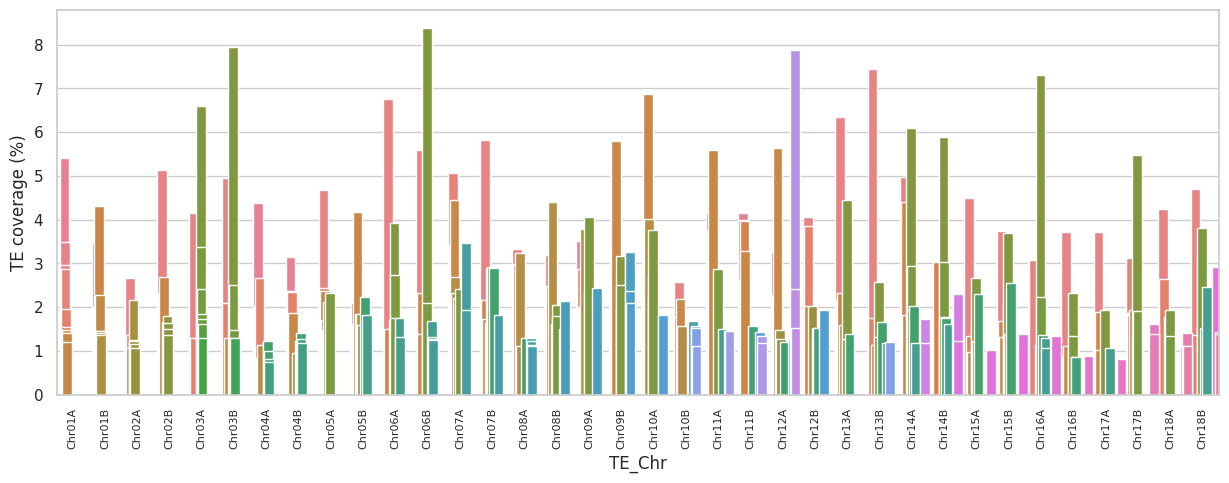

In [134]:

#Plot the coverage of top 10 TE families in centromeric regions, stacked by TE family
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
plt.figure(figsize=(15, 5))
sns.barplot(x='TE_Chr', y='coverage', hue='TE_family', data=top10_centromere)
#Change bar width
for bar in plt.gca().patches:
    bar.set_width(0.3)
    bar.set_x(bar.get_x() )
#rotate x-axis labels
plt.xticks(rotation=90)
#change x font size
plt.xticks(fontsize=8)
plt.ylabel('TE coverage (%)')
plt.legend().set_visible(False)
plt.show()

In [135]:
top10_centromere[top10_centromere['TE_Chr'] == 'Chr12A']

,chrom,start,end,TE_Chr,TE_family,TE_length,coverage
220,Chr12A,20365704,22565704,Chr12A,Motif:RLX-incomp-chim_MCL1_MR_P2A_300Mb-L-B655...,173169,7.871318
221,Chr12A,20365704,22565704,Chr12A,Motif:RLX-incomp-chim_MCL1_MR_P2A_100Mb_RS_5_r...,124024,5.637455
222,Chr12A,20365704,22565704,Chr12A,Motif:RLX-incomp-chim_MCL3_MR_P2A_100Mb_RS_2_r...,71847,3.265773
223,Chr12A,20365704,22565704,Chr12A,Motif:RXX-TRIM_MCL646_MR_P2A_300Mb-L-B5944-Map1,53094,2.413364
224,Chr12A,20365704,22565704,Chr12A,Motif:RLX-incomp-chim_MCL1_MR_P2A_300Mb-B-P12....,50004,2.272909
225,Chr12A,20365704,22565704,Chr12A,Motif:RXX-LARD_MCL604_MR_P2A_300Mb-L-B5600-Map1,33516,1.523455
226,Chr12A,20365704,22565704,Chr12A,Motif:RLX-comp_MCL1_MR_P2A_100Mb_RS_11,32421,1.473682
227,Chr12A,20365704,22565704,Chr12A,Motif:RLX-incomp-chim_MCL1_MR_P2A_300Mb-L-B385...,28010,1.273182
228,Chr12A,20365704,22565704,Chr12A,Motif:RLX-incomp-chim_MCL1_MR_P2A_300Mb-B-P4.0...,27996,1.272545
229,Chr12A,20365704,22565704,Chr12A,Motif:RLX-incomp-chim_MCL1_MR_P2A_100Mb_RS_3_r...,26683,1.212864


In [136]:
top10_centromere[top10_centromere['TE_Chr'] == 'Chr12B']

,chrom,start,end,TE_Chr,TE_family,TE_length,coverage
230,Chr12B,32385881,33885881,Chr12B,Motif:RLX-incomp-chim_MCL3_MR_P2A_100Mb_RS_2_r...,60972,4.064800
231,Chr12B,32385881,33885881,Chr12B,Motif:RLX-incomp_MCL8_MR_P2A_300Mb-B-P293.0-Map5,57748,3.849867
232,Chr12B,32385881,33885881,Chr12B,Motif:RLX-comp_MCL1_MR_P2A_100Mb_RS_11,30329,2.021933
233,Chr12B,32385881,33885881,Chr12B,Motif:RLX-incomp-chim_MCL1_MR_P2A_300Mb-B-P12....,30276,2.018400
234,Chr12B,32385881,33885881,Chr12B,Motif:RLX-incomp-chim_MCL1_MR_P2A_300Mb-B-P21....,29105,1.940333
235,Chr12B,32385881,33885881,Chr12B,Motif:RLX-comp_MCL1_MR_P2A_300Mb-B-P285.0-Map7...,27520,1.834667
236,Chr12B,32385881,33885881,Chr12B,Motif:RLX-incomp-chim_MCL1_MR_P2A_300Mb-L-B623...,22986,1.532400
237,Chr12B,32385881,33885881,Chr12B,Motif:RLX-incomp-chim_MCL1_MR_P2A_100Mb_RS_3_r...,22957,1.530467
238,Chr12B,32385881,33885881,Chr12B,Motif:DTX-incomp-chim_MCL23_MR_P2A_300Mb-L-B69...,19676,1.311733
239,Chr12B,32385881,33885881,Chr12B,Motif:RLX-incomp_MCL37_MR_P2A_300Mb-B-P265.0-Map3,18610,1.240667


In [119]:
top10_centromere

,chrom,start,end,TE_Chr,TE_family,TE_length,coverage
0,Chr01A,40800000,42300001,Chr01A,Motif:RLX-comp_MCL1_MR_P2A_300Mb-B-P285.0-Map7...,81088,0.054059
1,Chr01A,40800000,42300001,Chr01A,Motif:RLX-comp_MCL1_MR_P2A_300Mb-L-B2214-Map1,52383,0.034922
2,Chr01A,40800000,42300001,Chr01A,Motif:RLX-incomp-chim_MCL3_MR_P2A_100Mb_RS_2_r...,44382,0.029588
3,Chr01A,40800000,42300001,Chr01A,Motif:DTX-incomp-chim_MCL23_MR_P2A_300Mb-L-B69...,43033,0.028689
4,Chr01A,40800000,42300001,Chr01A,Motif:RLX-incomp_MCL8_MR_P2A_300Mb-B-P293.0-Map5,29399,0.019599
...,...,...,...,...,...,...,...
355,Chr18B,4285349,4985349,Chr18B,Motif:DTX-incomp-chim_MCL13_MR_P2A_300Mb-L-B17...,10836,0.015480
356,Chr18B,4285349,4985349,Chr18B,Motif:RLX-incomp-chim_MCL1_MR_P2A_100Mb_RS_3_r...,10686,0.015266
357,Chr18B,4285349,4985349,Chr18B,Motif:RLX-comp_MCL6_MR_P2A_300Mb-L-B1932-Map1,10008,0.014297
358,Chr18B,4285349,4985349,Chr18B,Motif:RLX-comp_MCL8_MR_P2A_300Mb-B-P273.0-Map8,9672,0.013817


In [87]:
top_list = top20.groupby('TE_family').count().sort_values('TE_Chr', ascending=False)

In [91]:
top_list_unique = top_list[top_list['TE_length'] == 1]

In [94]:
to_check_df = pd.DataFrame()
for i in top_list_unique['TE_family']:
    tmp = centromere_TE_intersect_bed[centromere_TE_intersect_bed['TE_family'] == i]
    to_check_df = pd.concat([to_check_df, tmp])

In [95]:
to_check_df

,TE_Chr,TE_Start,TE_End,id,Div,Strand,TE_family,CpG_count,GpC_count,CpG/GpC,mCpG_count,mCpG/CpG,TE_length
2993,Chr04A,35156956,35170008,Chr04A:35156956-35170008,13.8,+,Motif:RLX-incomp_MCL1_MR_P2A_300Mb-L-B526-Map1...,27,342,0.078947,10.0,0.370370,13052
9863,Chr12A,20601028,20604513,Chr12A:20601028-20604513,15.1,+,Motif:RLX-incomp_MCL1_MR_P2A_300Mb-L-B4163-Map1,10,115,0.086957,5.0,0.500000,3485
9933,Chr12A,20833864,20837350,Chr12A:20833864-20837350,15.1,-,Motif:RLX-incomp_MCL1_MR_P2A_300Mb-L-B4163-Map1,10,114,0.087719,7.0,0.700000,3486
9963,Chr12A,20942850,20946333,Chr12A:20942850-20946333,14.9,+,Motif:RLX-incomp_MCL1_MR_P2A_300Mb-L-B4163-Map1,10,114,0.087719,5.0,0.500000,3483
10012,Chr12A,21115029,21118515,Chr12A:21115029-21118515,15.0,+,Motif:RLX-incomp_MCL1_MR_P2A_300Mb-L-B4163-Map1,10,113,0.088496,3.0,0.300000,3486
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4364,Chr05B,20619237,20622237,Chr05B:20619237-20622237,5.2,+,Motif:RLX-incomp-chim_MCL1_MR_P2A_300Mb-L-B488...,15,41,0.365854,4.0,0.266667,3000
4446,Chr05B,20622221,20629453,Chr05B:20622221-20629453,4.0,+,Motif:RLX-incomp-chim_MCL1_MR_P2A_300Mb-L-B488...,18,180,0.100000,6.0,0.333333,7232
5541,Chr07A,13411832,13414066,Chr07A:13411832-13414066,15.7,+,Motif:RLX-incomp-chim_MCL1_MR_P2A_300Mb-L-B488...,12,44,0.272727,3.0,0.250000,2234
12621,Chr15A,12154534,12156534,Chr15A:12154534-12156534,15.6,-,Motif:RLX-incomp-chim_MCL1_MR_P2A_300Mb-L-B488...,6,30,0.200000,1.0,0.166667,2000


In [68]:
centromere_df = centromere.to_dataframe()
TE_length_df = TE_length.merge(centromere_df, left_on='TE_Chr', right_on='chrom', how='left')
TE_length_df['centromere_size'] = TE_length_df['end'] - TE_length_df['start']
TE_length_df['TE_length_percentage'] = TE_length_df['TE_length'] *100/ TE_length_df['centromere_size']

In [75]:
TE_length_chr = TE_length_df.groupby(['TE_family', 'TE_Chr']).sum('TE_length_percentage').reset_index()

In [80]:
#Order by TE_Chr and TE_length_percentage
TE_length_chr.sort_values(['TE_Chr', 'TE_length_percentage','TE_family'], ascending=False)
top20_TE_family = TE_length_chr.groupby('TE_Chr').apply(lambda x: x.nlargest(20, 'TE_length_percentage')).reset_index(drop=True)
top20_TE_family

/tmp/ipykernel_18699/2593416290.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top20_TE_family = TE_length_chr.groupby('TE_Chr').apply(lambda x: x.nlargest(20, 'TE_length_percentage')).reset_index(drop=True)


,TE_family,TE_Chr,TE_length,start,end,centromere_size,TE_length_percentage
0,Motif:RLX-comp_MCL1_MR_P2A_300Mb-B-P285.0-Map7...,Chr01A,81088,40800000,42300001,1500001,5.405863
1,Motif:RLX-comp_MCL1_MR_P2A_300Mb-L-B2214-Map1,Chr01A,52383,40800000,42300001,1500001,3.492198
2,Motif:RLX-incomp-chim_MCL3_MR_P2A_100Mb_RS_2_r...,Chr01A,44382,40800000,42300001,1500001,2.958798
3,Motif:DTX-incomp-chim_MCL23_MR_P2A_300Mb-L-B69...,Chr01A,43033,40800000,42300001,1500001,2.868865
4,Motif:RLX-incomp_MCL8_MR_P2A_300Mb-B-P293.0-Map5,Chr01A,29399,40800000,42300001,1500001,1.959932
...,...,...,...,...,...,...,...
715,Motif:RLX-incomp-chim_MCL29_MR_P2A_300Mb-L-B34...,Chr18B,7272,4285349,4985349,700000,1.038857
716,Motif:RLX-incomp_MCL1_MR_P2A_300Mb-L-B482-Map1...,Chr18B,7256,4285349,4985349,700000,1.036571
717,Motif:RLX-incomp-chim_MCL5_MR_P2A_300Mb-L-B22-...,Chr18B,7255,4285349,4985349,700000,1.036429
718,Motif:DTX-incomp-chim_MCL5_MR_P2A_300Mb-L-B563...,Chr18B,7240,4285349,4985349,700000,1.034286


In [81]:
top20_TE_family

,TE_family,TE_Chr,TE_length,start,end,centromere_size,TE_length_percentage
0,Motif:RLX-comp_MCL1_MR_P2A_300Mb-B-P285.0-Map7...,Chr01A,81088,40800000,42300001,1500001,5.405863
1,Motif:RLX-comp_MCL1_MR_P2A_300Mb-L-B2214-Map1,Chr01A,52383,40800000,42300001,1500001,3.492198
2,Motif:RLX-incomp-chim_MCL3_MR_P2A_100Mb_RS_2_r...,Chr01A,44382,40800000,42300001,1500001,2.958798
3,Motif:DTX-incomp-chim_MCL23_MR_P2A_300Mb-L-B69...,Chr01A,43033,40800000,42300001,1500001,2.868865
4,Motif:RLX-incomp_MCL8_MR_P2A_300Mb-B-P293.0-Map5,Chr01A,29399,40800000,42300001,1500001,1.959932
...,...,...,...,...,...,...,...
715,Motif:RLX-incomp-chim_MCL29_MR_P2A_300Mb-L-B34...,Chr18B,7272,4285349,4985349,700000,1.038857
716,Motif:RLX-incomp_MCL1_MR_P2A_300Mb-L-B482-Map1...,Chr18B,7256,4285349,4985349,700000,1.036571
717,Motif:RLX-incomp-chim_MCL5_MR_P2A_300Mb-L-B22-...,Chr18B,7255,4285349,4985349,700000,1.036429
718,Motif:DTX-incomp-chim_MCL5_MR_P2A_300Mb-L-B563...,Chr18B,7240,4285349,4985349,700000,1.034286
